<a id = "toc"></a>
# Custom Functions
This notebook contains all custom functions created to facilitate the data mining process. The function groups:  
  
1. [Feature Generation](#feat_gen)
2. [Data Preparation](#dat_prep)
3. [Model Fitting and Scoring](#fit_score)
4. [Grid Search](#grid_search)
4. [Recursive Feature Elimination with Cross Validation](#rfecv)

## Modules Required

In [23]:
# Import required modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from joblib import Parallel, delayed
from scipy import stats
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE


# Settings
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

## Help Function

In [1]:
# Help function
def helpme():
    
    # Print
    print(
        """
        * ------------------------------- *
        | KAGGLE TITANIC HELPER FUNCTIONS |
        * ------------------------------- *
        
        # ---- INTRODUCTION ---- #
        The Kaggle Titanic module provides functions for end-to-end data mining, from data cleaning to feature generation
        to dataset splitting to model tuning.
        
        # ---- DATA CLEANING AND FEATURE GENERATION ---- #
        
        [ clean_all(df) ]
        
        Generates generic features for all data (train and test). This includes features for one-hot encoding (OH), ordinal
        categorical features (OC), binaries (BN), and numerics (NM). Numeric features in both the training and test set are
        not encoded at this stage.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ encode_train(df) ]
        
        Takes training data, performs mean encoding, and returns a cleaned training set, along with the mapping used.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ map_test(df, mapping) ]
        
        Takes test data and the mapping generated from encode_train, and outputs a cleaned test set.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ get_folds(df, random_state) ]
        
        Takes a dataset and splits it using RepeatedStratifiedKFold() with 5 repeats and 5 folds.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ split_train_test(df, folds, setno) ]
        
        Takes a set number (between 1 and 25), and splits data into training features, training labels, test features, and 
        test labels. Returns a tuple of length 4.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ prep_sets(df, folds, n_jobs = 3, sets = list(np.arange(1,26,1))) ]
        
        Splits data into a list of tuples, each of length 4. The training sets are specified using the "sets" argument.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ fit_score(estimator, sep_sets) ]
        
        Takes a model and a tuple of training and test features and labels, and returns a score.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ score_sets(estimator, all_sets, n_jobs = 3, verbose = False) ]
        
        Performs scoring on given pairs of train/test sets.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ score_grid_single(estimator, param, pval, all_sets, n_jobs = 3, verbose = False) ]
        
        Perform scoring on given train/test sets for a single parameter value.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ score_grid(estimator, params, all_sets, n_jobs = 3, verbose = False) ]
        
        Perform scoring on given train/test sets for a list of parameter values. Can only tune one parameter.
        
        -------------------------------------------------------------------------------------------------------------------
        
        [ custom_rfecv(estimator, nfeats, sub_sets, df, step = 1, n_jobs = 3, verbose = True) ]
        
        Perform RFE on all possible values (1 to total no. of features) for all given sets.
        
        -------------------------------------------------------------------------------------------------------------------
        """
    )

<a id = "feat_gen"></a>
## Feature Generation
[[Back to Table of Contents]](#toc)  
  
This series of functions were used to (1) clean train and test data, (2) encode training data and extract the mappings, and (3) map the conversions to test data.

In [11]:
# Clean all data
def clean_all(input_df):
    
    # Copy data
    df = input_df.copy()
    
    # ---- PCLASS ---- #
    df['pclass_OH'] = 'CLASS' + df.Pclass.astype('str')
    df['pclass_OC'] = df.pclass_OH.astype('category', ordered = True, categories = ['CLASS3', 'CLASS2', 'CLASS1']).cat.codes

    # ---- TITLE ---- #
    df['title_OH'] = df.Name.str.replace('.*, ', '').str.replace(' .*', '')
    df.title_OH[(df.title_OH != 'Mr.') & (df.title_OH != 'Miss.') & (df.title_OH != 'Mrs.') & (df.title_OH != 'Master.')] = 'Other'

    # ---- SEX ---- #
    df['sex_BN'] = df.Sex.astype('category').cat.codes
    df['sex_OH'] = df.Sex.copy()

    # ---- SIBSP ---- #
    df['sibsp_OH'] = 'None'
    df['sibsp_OH'][df['SibSp'] == 1] = 'One'
    df['sibsp_OH'][df['SibSp'] >= 2] = 'Two or More'
    df['sibsp_NM'] = df['SibSp'].copy()
    df['sibsp_OC'] = df['sibsp_OH'].astype('category', ordered = True, categories = ['None', 'One', 'Two or More']).cat.codes

    # ---- PARCH ---- #
    df['parch_OH'] = 'None'
    df['parch_OH'][df['Parch'] == 1] = 'One'
    df['parch_OH'][df['Parch'] >= 2] = 'Two or More'
    df['parch_NM'] = df['Parch'].copy()
    df['parch_OC'] = df['parch_OH'].astype('category', ordered = True, categories = ['None', 'One', 'Two or More']).cat.codes

    # ---- TICKET NUMBER ---- #
    df['Ticket'] = df.Ticket.str.replace('[a-zA-z\\.]', '').str.replace('[\\/.* ]', '')
    df['ticlen_OH'] = 'L' + df['Ticket'].str.len().astype(str)
    df['ticlen_OH'][df['Ticket'].str.len().isin([0,1,3,7,8])] = 'LO'

    # ---- FARE ---- #
    df['fare_NM'] = df.Fare.copy()
    df['fare_NM'][df.Fare > 150] = 150
    df['fare_OC'] = pd.qcut(df.fare_NM, 6).astype('category').cat.codes
    df['fare_OH'] = 'G' + df.fare_OC.astype(str)

    # ---- CABIN LETTERS ---- #
    df['cab_letter'] = df.Cabin.str[0]
    df['cab_letter'][df.Cabin.isnull()] = 'NIL'
    df['cabletter_OH'] = 'B/D/E'
    df['cabletter_OH'][df.cab_letter.isin(['A', 'G', 'T', 'C', 'F'])] = 'Others'
    df['cabletter_OH'][df.cab_letter.isin(['NIL'])] = 'NIL'

    # ---- CABIN NUMBERS ---- #
    temp_df = df.Cabin.str.replace('[a-zA-z]', '').str.split(' ', expand = True)
    temp_df.columns = ['a','b','c','d']
    temp_df.a = pd.to_numeric(temp_df.a, errors = 'coerce')
    temp_df.b = pd.to_numeric(temp_df.b, errors = 'coerce')
    temp_df.c = pd.to_numeric(temp_df.c, errors = 'coerce')
    temp_df.d = pd.to_numeric(temp_df.d, errors = 'coerce')
    df['cab_no'] = temp_df.mean(axis = 1)
    df['cabno_OH'] = 'C1'
    df['cabno_OH'][(df.cab_no > 35) & (df.cab_no <= 49)] = 'C2'
    df['cabno_OH'][(df.cab_no > 70.143) & (df.cab_no <= 96.143)] = 'C2'
    df['cabno_OH'][df.cab_no.isnull()] = 'NIL'

    # ---- EMBARKED ---- #
    df['embarked_OH'] = df.Embarked.copy()
    df['embarked_OH'][df['embarked_OH'].isnull()] = 'C'

    # ---- FINAL CLEANING ---- #
    # Drop variables
    df = df.drop(['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'cab_letter', 'cab_no', 'Cabin', 'Embarked'], axis = 1)
    
    # Output
    return df

# Encode training data
def encode_train(input_df):
    
    # Copy data
    df = input_df.copy()
    
    # Initialise mappings
    mapping = dict()
    
    # ---- AGE ---- #
    # Set seed
    seed = 123

    # Mask for missing ages
    miss_age = df.Age.isnull()

    # Masks for each title
    miss_master = df.title_OH == 'Master.'
    miss_ms = df.title_OH == 'Miss.'
    miss_mr = df.title_OH == 'Mr.'
    miss_mrs = df.title_OH == 'Mrs.'
    miss_other = df.title_OH == 'Other'

    # Impute ages
    np.random.seed(seed)
    df['Age'][miss_age & miss_master] = np.random.normal(
        df.groupby('title_OH').Age.median()[0],
        df.groupby('title_OH').Age.std()[0] * 0.5,
        df['Age'][miss_age & miss_master].shape[0]
    )

    df['Age'][miss_age & miss_ms] = np.random.normal(
        df.groupby('title_OH').Age.median()[1],
        df.groupby('title_OH').Age.std()[1] * 0.5,
        df['Age'][miss_age & miss_ms].shape[0]
    )

    df['Age'][miss_age & miss_mr] = np.random.normal(
        df.groupby('title_OH').Age.median()[2],
        df.groupby('title_OH').Age.std()[2] * 0.5,
        df['Age'][miss_age & miss_mr].shape[0]
    )

    df['Age'][miss_age & miss_mrs] = np.random.normal(
        df.groupby('title_OH').Age.median()[3],
        df.groupby('title_OH').Age.std()[3] * 0.5,
        df['Age'][miss_age & miss_mrs].shape[0]
    )

    df['Age'][miss_age & miss_other] = np.random.normal(
        df.groupby('title_OH').Age.median()[4],
        df.groupby('title_OH').Age.std()[4] * 0.5,
        df['Age'][miss_age & miss_other].shape[0]
    )
    
    # Add to mapping
    mapping['age_master'] = (df.groupby('title_OH').Age.median()[0], df.groupby('title_OH').Age.std()[0] * 0.5)
    mapping['age_ms'] = (df.groupby('title_OH').Age.median()[1], df.groupby('title_OH').Age.std()[1] * 0.5)
    mapping['age_mr'] = (df.groupby('title_OH').Age.median()[2], df.groupby('title_OH').Age.std()[2] * 0.5)
    mapping['age_mrs'] = (df.groupby('title_OH').Age.median()[3], df.groupby('title_OH').Age.std()[3] * 0.5)
    mapping['age_other'] = (df.groupby('title_OH').Age.median()[4], df.groupby('title_OH').Age.std()[4] * 0.5)
    
    # Split into 10 quantiles
    df['age_OC'] = pd.qcut(df.Age, 10).astype('category').cat.codes
    _, mapping['age_bins'] = pd.qcut(df.Age, 10, retbins = True)

    # Age features
    df['age_NM'] = df.Age
    df['age_OH'] = 'A' + df.age_OC.astype(str)
    
    # ---- PCLASS ---- #
    map_pclass = df.groupby('pclass_OH').Survived.mean()
    mapping['pclass_ME'] = map_pclass
    df['pclass_ME'] = df.pclass_OH.map(map_pclass)
    
    # ---- TITLE ---- #
    map_title = df.groupby('title_OH').Survived.mean()
    mapping['title_ME'] = map_title
    df['title_ME'] = df.title_OH.map(map_title)
    
    # ---- AGE ---- #
    map_age = df.groupby('age_OH').Survived.mean()
    mapping['age_ME'] = map_age
    df['age_ME'] = df.age_OH.map(map_age)
    
    # ---- SIBSP ---- #
    map_sibsp = df.groupby('sibsp_OH').Survived.mean()
    mapping['sibsp_ME'] = map_sibsp
    df['sibsp_ME'] = df.sibsp_OH.map(map_sibsp)
    
    # ---- PARCH ---- #
    map_parch = df.groupby('parch_OH').Survived.mean()
    mapping['parch_ME'] = map_parch
    df['parch_ME'] = df.parch_OH.map(map_parch)
    
    # ---- TICKET ---- #
    map_ticlen = df.groupby('ticlen_OH').Survived.mean()
    mapping['ticlen_ME'] = map_ticlen
    df['ticlen_ME'] = df['ticlen_OH'].map(map_ticlen)
    
    # ---- FARE ---- #
    map_fare = df.groupby('fare_OH').Survived.mean()
    mapping['fare_ME'] = map_fare
    df['fare_ME'] = df['fare_OH'].map(map_fare)
    
    # ---- CAB LETTER ---- #
    map_cabletter = df.groupby('cabletter_OH').Survived.mean()
    mapping['cabletter_ME'] = map_cabletter
    df['cabletter_ME'] = df['cabletter_OH'].map(map_cabletter)
    
    # ---- CAB NUMBER ---- #
    map_cabno = df.groupby('cabno_OH').Survived.mean()
    mapping['cabno_ME'] = map_cabno
    df['cabno_ME'] = df['cabno_OH'].map(map_cabno)
    
    # ---- EMBARKED ---- #
    map_embarked = df.groupby('embarked_OH').Survived.mean()
    mapping['embarked_ME'] = map_embarked
    df['embarked_ME'] = df['embarked_OH'].map(map_embarked)
    
    # Drop age
    df = df.drop('Age', axis = 1)
    
    # Output
    output = (df, mapping)
    
    return output

# Map to test data
def map_test(input_df, mapping):
    
    # Copy data
    df = input_df.copy()
    
    # All mapping
    # ---- AGE ---- #
    # Set seed
    seed = 123

    # Mask for missing ages
    miss_age = df.Age.isnull()

    # Masks for each title
    miss_master = df.title_OH == 'Master.'
    miss_ms = df.title_OH == 'Miss.'
    miss_mr = df.title_OH == 'Mr.'
    miss_mrs = df.title_OH == 'Mrs.'
    miss_other = df.title_OH == 'Other'

    # Impute ages
    np.random.seed(seed)
    df['Age'][miss_age & miss_master] = np.random.normal(
        mapping['age_master'][0],
        mapping['age_master'][1] * 0.5,
        df['Age'][miss_age & miss_master].shape[0]
    )

    df['Age'][miss_age & miss_ms] = np.random.normal(
        mapping['age_ms'][0],
        mapping['age_ms'][1] * 0.5,
        df['Age'][miss_age & miss_ms].shape[0]
    )

    df['Age'][miss_age & miss_mr] = np.random.normal(
        mapping['age_mr'][0],
        mapping['age_mr'][1] * 0.5,
        df['Age'][miss_age & miss_mr].shape[0]
    )

    df['Age'][miss_age & miss_mrs] = np.random.normal(
        mapping['age_mrs'][0],
        mapping['age_mrs'][1] * 0.5,
        df['Age'][miss_age & miss_mrs].shape[0]
    )

    df['Age'][miss_age & miss_other] = np.random.normal(
        mapping['age_other'][0],
        mapping['age_other'][1] * 0.5,
        df['Age'][miss_age & miss_other].shape[0]
    )
    
    # Split into 10 quantiles
    bins = mapping['age_bins']
    df['age_OC'] = 0
    df['age_OC'][(df.Age > bins[1]) & (df.Age <= bins[2])] = 1
    df['age_OC'][(df.Age > bins[2]) & (df.Age <= bins[3])] = 2
    df['age_OC'][(df.Age > bins[3]) & (df.Age <= bins[4])] = 3
    df['age_OC'][(df.Age > bins[4]) & (df.Age <= bins[5])] = 4
    df['age_OC'][(df.Age > bins[5]) & (df.Age <= bins[6])] = 5
    df['age_OC'][(df.Age > bins[6]) & (df.Age <= bins[7])] = 6
    df['age_OC'][(df.Age > bins[7]) & (df.Age <= bins[8])] = 7
    df['age_OC'][(df.Age > bins[8]) & (df.Age <= bins[9])] = 8
    df['age_OC'][(df.Age > bins[9]) & (df.Age <= bins[10])] = 9

    # Age features
    df['age_NM'] = df.Age
    df['age_OH'] = 'A' + df.age_OC.astype(str)
    df['age_ME'] = df.age_OH.map(mapping['age_ME'])
    
    # Remove age
    df = df.drop('Age', axis = 1)
    
    # ---- PCLASS ---- #
    df['pclass_ME'] = df.pclass_OH.map(mapping['pclass_ME'])
    
    # ---- TITLE ---- #
    df['title_ME'] = df.title_OH.map(mapping['title_ME'])
    
    # ---- SIBSP ---- #
    df['sibsp_ME'] = df.sibsp_OH.map(mapping['sibsp_ME'])
    
    # ---- PARCH ---- #
    df['parch_ME'] = df.parch_OH.map(mapping['parch_ME'])
    
    # ---- TICKET ---- #
    df['ticlen_ME'] = df['ticlen_OH'].map(mapping['ticlen_ME'])
    
    # ---- FARE ---- #
    df['fare_ME'] = df['fare_OH'].map(mapping['fare_ME'])
    
    # ---- CAB LETTER ---- #
    df['cabletter_ME'] = df['cabletter_OH'].map(mapping['cabletter_ME'])
    
    # ---- CAB NUMBER ---- #
    df['cabno_ME'] = df['cabno_OH'].map(mapping['cabno_ME'])
    
    # ---- EMBARKED ---- #
    df['embarked_ME'] = df['embarked_OH'].map(mapping['embarked_ME'])
    
    # Output
    return df

### Usage

In [12]:
# Read data
df = pd.read_csv('train.csv')

# Clean entire dataset
df_clean = clean_all(df)

# View
df_clean.head()

,Survived,Age,pclass_OH,pclass_OC,title_OH,sex_BN,sex_OH,sibsp_OH,sibsp_NM,sibsp_OC,parch_OH,parch_NM,parch_OC,ticlen_OH,fare_NM,fare_OC,fare_OH,cabletter_OH,cabno_OH,embarked_OH
0,0,22.0,CLASS3,0,Mr.,1,male,One,1,1,None,0,0,L6,7.2500,0,G0,NIL,NIL,S
1,1,38.0,CLASS1,2,Mrs.,0,female,One,1,1,None,0,0,L5,71.2833,5,G5,Others,C2,C
2,1,26.0,CLASS3,0,Miss.,0,female,None,0,0,None,0,0,LO,7.9250,1,G1,NIL,NIL,S
3,1,35.0,CLASS1,2,Mrs.,0,female,One,1,1,None,0,0,L6,53.1000,5,G5,Others,C1,S
4,0,35.0,CLASS3,0,Mr.,1,male,None,0,0,None,0,0,L6,8.0500,1,G1,NIL,NIL,S


In [13]:
# Split into train and test set
train_clean = df_clean.iloc[:700, :]
test_clean = df_clean.iloc[700:, :]

# Encode full set
df_encoded, _ = encode_train(df_clean)

# Encode train set
train_encoded, mapping = encode_train(train_clean)

# Map test
test_encoded = map_test(test_clean, mapping)

# View
train_encoded.head()

,Survived,pclass_OH,pclass_OC,title_OH,sex_BN,sex_OH,sibsp_OH,sibsp_NM,sibsp_OC,parch_OH,...,pclass_ME,title_ME,age_ME,sibsp_ME,parch_ME,ticlen_ME,fare_ME,cabletter_ME,cabno_ME,embarked_ME
0,0,CLASS3,0,Mr.,1,male,One,1,1,None,...,0.253886,0.162162,0.271429,0.524096,0.354597,0.316860,0.213675,0.311234,0.312614,0.338645
1,1,CLASS1,2,Mrs.,0,female,One,1,1,None,...,0.603550,0.776596,0.437500,0.524096,0.354597,0.558974,0.686441,0.564103,0.547619,0.540741
2,1,CLASS3,0,Miss.,0,female,None,0,0,None,...,0.253886,0.712418,0.275362,0.352442,0.354597,0.311111,0.209677,0.311234,0.312614,0.338645
3,1,CLASS1,2,Mrs.,0,female,One,1,1,None,...,0.603550,0.776596,0.456140,0.524096,0.354597,0.316860,0.686441,0.564103,0.693694,0.338645
4,0,CLASS3,0,Mr.,1,male,None,0,0,None,...,0.253886,0.162162,0.456140,0.352442,0.354597,0.316860,0.209677,0.311234,0.312614,0.338645


In [10]:
# View
test_encoded.head()

,Survived,pclass_OH,pclass_OC,title_OH,sex_BN,sex_OH,sibsp_OH,sibsp_NM,sibsp_OC,parch_OH,...,age_ME,pclass_ME,title_ME,sibsp_ME,parch_ME,ticlen_ME,fare_ME,cabletter_ME,cabno_ME,embarked_ME
700,1,CLASS1,2,Mrs.,0,female,One,1,1,None,...,0.413333,0.603550,0.776596,0.524096,0.354597,0.558974,0.686441,0.564103,0.693694,0.540741
701,1,CLASS1,2,Mr.,1,male,None,0,0,None,...,0.456140,0.603550,0.162162,0.352442,0.354597,0.558974,0.398305,0.734177,0.693694,0.338645
702,0,CLASS3,0,Miss.,0,female,None,0,0,One,...,0.413333,0.253886,0.712418,0.352442,0.511111,0.336207,0.382353,0.311234,0.312614,0.540741
703,0,CLASS3,0,Mr.,1,male,None,0,0,None,...,0.369231,0.253886,0.162162,0.352442,0.354597,0.558974,0.213675,0.311234,0.312614,0.444444
704,0,CLASS3,0,Mr.,1,male,One,1,1,None,...,0.275362,0.253886,0.162162,0.524096,0.354597,0.316860,0.209677,0.311234,0.312614,0.338645


<a id = "dat_prep"></a>
## Data Preparation
[[Back to Table of Contents]](#toc)  
  

### Function to split data into folds (indices)
This function implements repeated (5) stratified 5-fold splitting. It takes in a dataframe (with features and target) and a random state, and returns a dictionary with 25 entries. Each entry in turn has two entries: (1) the indices of training samples and (2) the indices of test samples.

In [15]:
# Get indices for Repeated Stratified K Folds
def get_folds(df, random_state):
    
    # Initialise output
    output = dict()

    # Initialise counter
    counter = 1
    
    # Create labels
    y = df['Survived']
    
    # Separate features
    X = df.drop('Survived', axis = 1)
    
    # Create
    rkf = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=random_state)
    
    # Loop through folds
    for tr_index, te_index in rkf.split(X, y):

        # Append to dictionary
        output['set' + str(counter)] = dict()
        output['set' + str(counter)]['train'] = tr_index
        output['set' + str(counter)]['test'] = te_index
        
        # Update counter
        counter += 1
    
    # Return
    return output

#### Usage

In [16]:
# Get folds
folds = get_folds(df_clean, random_state=123)

# Result
print(len(folds))
print(type(folds))
print(folds.keys())

25
<class 'dict'>
dict_keys(['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8', 'set9', 'set10', 'set11', 'set12', 'set13', 'set14', 'set15', 'set16', 'set17', 'set18', 'set19', 'set20', 'set21', 'set22', 'set23', 'set24', 'set25'])


### Function to split data into training and testing features and target
This function takes in a complete dataset (with features and targets), the fold indices, a set number (1-25), and a boolean to determine if the output is a tuple (`group = True`) or four variables (`group = False`).

In [19]:
# Split data into X_train, y_train, X_test, y_test
def split_train_test(df, folds, setno, feats = False):
    
    # Access set number
    temp_indices = folds['set' + str(setno)]
    
    # Configure train and test data
    train = df.iloc[temp_indices['train'], :]
    test = df.iloc[temp_indices['test'], :]
    
    # Encode train data
    train_encoded, temp_map = encode_train(train)
    
    # Map test data
    test_encoded = map_test(test, temp_map)
    
    # Separate features from target
    X_train = train_encoded.drop('Survived', axis = 1)
    X_train = pd.get_dummies(X_train)
    y_train = train_encoded['Survived']
    
    X_test = test_encoded.drop('Survived', axis = 1)
    X_test = pd.get_dummies(X_test)
    y_test = test_encoded['Survived']
    
    # Check for non-overlapping columns
    rem_col = list(set(X_train.columns) - set(X_test.columns))
    
    # Remove from sets
    if X_train.columns.isin(rem_col).any():
        
        X_train = X_train.drop(rem_col, axis = 1)
    
    if X_test.columns.isin(rem_col).any():
        
        X_test = X_test.drop(rem_col, axis = 1)
    
    # Remove features
    if feats:
        
        selected_feats = [f for f in feats if np.sum(X_train.columns.isin([f]).any()) >= 1]
        X_train = X_train[selected_feats]
        X_test = X_test[selected_feats]
    
    # Output
    return (X_train, y_train, X_test, y_test)

#### Usage

In [20]:
# Get split data
a,b,c,d = split_train_test(df_clean, folds, 1)
a.head()

,pclass_OC,sex_BN,sibsp_NM,sibsp_OC,parch_NM,parch_OC,fare_NM,fare_OC,age_OC,age_NM,...,age_OH_A0,age_OH_A1,age_OH_A2,age_OH_A3,age_OH_A4,age_OH_A5,age_OH_A6,age_OH_A7,age_OH_A8,age_OH_A9
0,0,1,1,1,0,0,7.2500,0,2,22.000000,...,0,0,1,0,0,0,0,0,0,0
1,2,0,1,1,0,0,71.2833,5,7,38.000000,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,7.9250,1,3,26.000000,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,8.0500,1,6,35.000000,...,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,0,8.4583,1,3,24.882382,...,0,0,0,1,0,0,0,0,0,0


### Function to prepare sets in split form
This function takes a dataframe (with features and target), the fold indices in dictionary form (from `get_folds`), and a list of set indices, which is 1 to 25 inclusive by default. This allows us to vectorize all datasets (training and testing features and targets), which can then be fed into a function to perform fitting and prediction on the datasets extremely quickly.

In [21]:
# Get list of sets
def prep_sets(df, folds, n_jobs = 3, sets = list(np.arange(1,26,1)), feats = False):
    
    # Get all sets
    output = Parallel(n_jobs=n_jobs, verbose = False)(delayed(split_train_test)(df=df, folds=folds, setno=s,
                                                                               feats = feats) for s in sets)
    
    # Output
    return output

#### Usage

In [22]:
# Time code
import time
t0 = time.time()

# Prepare all sets
all_sets = prep_sets(df_clean, folds)

# Get time
time.time()-t0

19.339282512664795

In [12]:
# X_train from the 1st of 25 sets
all_sets[0][0].head()

,pclass_OC,sex_BN,age_OC,age_NM,sibsp_NM,sibsp_OC,parch_NM,parch_OC,fare_NM,fare_OC,...,fare_OH_G5,cabletter_OH_B/D/E,cabletter_OH_NIL,cabletter_OH_Others,cabno_OH_C1,cabno_OH_C2,cabno_OH_NIL,embarked_OH_C,embarked_OH_Q,embarked_OH_S
0,0,1,2,22.000000,1,1,0,0,7.2500,0,...,0,0,1,0,0,0,1,0,0,1
1,2,0,7,38.000000,1,1,0,0,71.2833,5,...,1,0,0,1,0,1,0,1,0,0
2,0,0,4,26.000000,0,0,0,0,7.9250,1,...,0,0,1,0,0,0,1,0,0,1
4,0,1,6,35.000000,0,0,0,0,8.0500,1,...,0,0,1,0,0,0,1,0,0,1
5,0,1,3,24.882382,0,0,0,0,8.4583,1,...,0,0,1,0,0,0,1,0,1,0


<a id = "fit_score"></a>
## Model Fitting and Scoring
[[Back to Table of Contents]](#toc)

### Function to fit and predict data
This function takes in a model and a tuple containing training and test features and targets (X_train, y_train, X_test, y_test). It fits the model and returns the score.

In [15]:
# Fit and predict
def fit_score(estimator, sep_sets):
    
    # Fit model
    estimator.fit(sep_sets[0], sep_sets[1])
    
    # Score model
    output = estimator.score(sep_sets[2], sep_sets[3])
    
    return output

### Function to perform scoring on all datasets provided
This function takes in a model and a list of tuples, each of which contains training and test features and targets (X_train, y_train, X_test, y_test). It fits the model and scores it with test data for all sets provided, and returns a list of scores with a length equal to the number of sets provided.

In [16]:
# Perform scoring on all provided sets
def score_sets(estimator, all_sets, n_jobs = 3, verbose = False):
    
    # Run
    output = Parallel(n_jobs=n_jobs, verbose = verbose)(delayed(fit_score)(estimator, d) for d in all_sets)
    
    return output

#### Usage

In [17]:
# Set up model
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(random_state=123)

t0 = time.time()
scores = score_sets(rf1, all_sets, n_jobs=4)
print('Time taken: ' + str(time.time() - t0))
print(scores)

Time taken: 1.562183141708374
[0.8156424581005587, 0.8491620111731844, 0.8314606741573034, 0.7865168539325843, 0.8135593220338984, 0.8212290502793296, 0.7988826815642458, 0.797752808988764, 0.7808988764044944, 0.8305084745762712, 0.8156424581005587, 0.8659217877094972, 0.8370786516853933, 0.7752808988764045, 0.8418079096045198, 0.8268156424581006, 0.8379888268156425, 0.7921348314606742, 0.8146067415730337, 0.8022598870056498, 0.8268156424581006, 0.7988826815642458, 0.8370786516853933, 0.7808988764044944, 0.7853107344632768]


### Function to score a specific parameter configuration on sets provided
This function takes a model, a parameter name (k), a single parameter value, and all sets to score the model on. It returns the mean score.

In [18]:
# Score model
def score_grid_single(estimator, param, pval, all_sets, n_jobs = 3, verbose = False):
    
    # Set parameter values
    model = estimator.set_params(**{param: pval})
    
    # Compute scores
    temp_scores = score_sets(
        estimator = model,
        all_sets = all_sets,
        n_jobs = n_jobs,
        verbose = verbose
    )
    
    # Return mean
    return np.mean(temp_scores)

<a id='grid_search'></a>
## Grid Search
[[Back to Table of Contents]](#toc)

### Function to perform grid search, ideally for a single parameter
This function takes the above function and applies it to all parameters in the parameter set provided. It prints the best mean test score and the optimal parameter value, plots the mean test score against the parameter values, and returns (1) a dataframe with the detailed results and (2) the optimal value.

In [19]:
# Single parameter grid search
def score_grid(estimator, params, all_sets, n_jobs = 3, verbose = False):
    
    # Output lists
    param = list(params.keys())[0]
    param_value = list(params.values())[0]
    mean_test_score = []
    
    # Compute mean test scores
    for pval in [v for k, v in params.items()][0]:
        
        # Update
        if verbose:
            print('Computing test scores for ' + param + ' = ' + str(pval) + '...', end = "", flush = True)
        
        # Compute score
        temp_score = score_grid_single(
                estimator = estimator,
                param = param,
                pval = pval,
                all_sets = all_sets,
                n_jobs = n_jobs
        )
        
        # Append
        mean_test_score.append(temp_score)
        
        # Update
        print('Done!')
    
    # Spacing
    print()
    print()
    
    # Print results
    max_score = np.max(mean_test_score)
    opt_value = param_value[np.argmax(mean_test_score)]
    print('[ RESULTS ]')
    print('   Best Score: ' + str(max_score))
    print('Optimal Value: ' + str(opt_value))
    
    # Plot
    plt.plot(param_value, mean_test_score)
    plt.title(param)
    plt.show()
    
    # Output
    output = pd.DataFrame([param_value, mean_test_score], index = ['param_value','mean_test_score']).T
    output.insert(0, "param", param)
    return (output, opt_value)

#### Usage

Computing test scores for n_estimators = 100...Done!
Computing test scores for n_estimators = 250...Done!
Computing test scores for n_estimators = 500...Done!
Computing test scores for n_estimators = 1000...Done!
Computing test scores for n_estimators = 1500...Done!
Computing test scores for n_estimators = 2000...Done!


[ RESULTS ]
   Best Score: 0.8237842290924811
Optimal Value: 2000


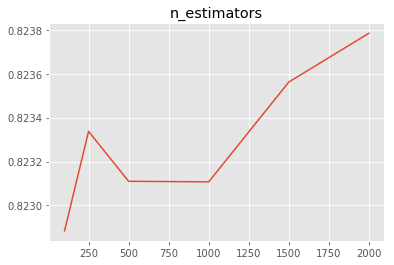

In [25]:
t1 = time.time()
all_res, best_n_estimators = score_grid(rf1, params, all_sets, n_jobs = 4)
old_sg_time = time.time() - t1

<a id='rfecv'></a>
## Recursive Feature Elimination with Cross Validation
[[Back to Table of Contents]](#toc)

### Functions to perform RFECV

In [115]:
def rfe_single(estimator, dat, n_jobs = 3, xg = False, verbose = False):
    
    # Set up RFE
    rfe = RFE(
        estimator = estimator,
        n_features_to_select = 1,
        step = 1,
        verbose = verbose
    )
    
    # Extract data
    X_train = dat[0]
    y_train = dat[1]
    X_test = dat[2]
    y_test = dat[3]
    
    # Set up scorer
    if xg:
        temp_scorer = lambda est, features: accuracy_score(y_true=y_test, y_pred=est.predict(X_test.values[:, features]))
    
    else:
        temp_scorer = lambda est, features: accuracy_score(y_true=y_test, y_pred=est.predict(X_test.iloc[:, features]))
    
    # Fit RFE
    rfe._fit(X_train, y_train, temp_scorer)
    
    # Return scores
    return rfe.scores_
    

In [124]:
# Function to perform RFECV
def custom_rfecv(estimator, sub_sets, df, step = 1, n_jobs = 3, xg = False, verbose = True):
    
    # Set parameters
    n_features = int(stats.mode([ sub_sets[i][0].shape[1] for i in range(len(sub_sets)) ], axis = None)[0])
    
    # Compute scores
    all_scores = Parallel(n_jobs=n_jobs, verbose = verbose)(delayed(rfe_single)(
        estimator=estimator, dat=d, n_jobs=n_jobs, xg = xg, verbose = False
    ) for d in sub_sets)
    
    # Check number of minimum entries
    score_lengths = [len(i) for i in all_scores]
    common = int(stats.mode(score_lengths, axis = None)[0])
    rem_idx = [i for i in range(len(score_lengths)) if score_lengths[i] != common]
    for idx in sorted(rem_idx, reverse=True):
        del all_scores[idx]
    
    # Consolidate scores
    all_scores = np.mean(all_scores, axis=0)
    n_features_to_select = max(n_features - (np.argmax(all_scores) * step), 1)
    
    # Print results
    max_score = np.max(all_scores)
    print('   Best Score: ' + str(max_score))
    print('Optimal Value: ' + str(n_features_to_select))
    
    # Estimate model
    opt_rfe = RFE(
            estimator = estimator,
            step = step,
            n_features_to_select = n_features_to_select
    )
    
    # Extract data
    X_final = pd.get_dummies(df.drop('Survived', axis = 1))
    y_final = df.Survived
    
    opt_rfe.fit(X_final, y_final)
    
    # Extract features
    opt_feats = X_final.columns[opt_rfe.ranking_ == 1]
    
    # Configure X-axis for plot
    feat_nums = list(np.arange(1, n_features+1, 1))
    
    # Plot
    plt.plot(feat_nums, list(reversed(all_scores)))
    plt.title("Mean Test Score vs. No. of Features")
    plt.show()
    
    # Output
    output = pd.DataFrame([n_features, all_scores], index = ['n_features','mean_test_score']).T
    return (output, n_features_to_select, opt_feats)

#### Usage

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:   16.9s finished


   Best Score: 0.8231125542461186
Optimal Value: 38


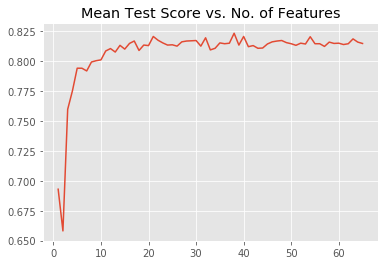

17.6979660987854


In [125]:
# Execute
t2 = time.time()
rfe_res, best_n_features, select_feats = custom_rfecv(
    estimator = rf1,
    sub_sets = all_sets,
    df = df_encoded,
    step = 1,
    n_jobs = 3,
    verbose = True
)

rfe_time = time.time() - t2
print(rfe_time)

In [5]:
import numpy as np
list(np.array([1,2,3]) ** 2)

[1, 4, 9]